# Data Cleaning and Feature Engineering

In [232]:
#importing libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import plotly.express as px
import shapely
from geopandas import GeoDataFrame,GeoSeries
import folium
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import dtale

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.neighbors import KNeighborsClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from dmba import regressionSummary, classificationSummary
!pip install xgboost --quiet
import xgboost as xgb

In [233]:
#reading in data
final_df = gpd.read_file('final_df.geojson')

In [234]:
final_df.head(2)

,centreline_id,road_name,road_hierarchy,road_classification,bikelane_present,number_of_lanes,pedestrian_crossover_present,speed_hump_count,traffic_island_count,speed_cushion_count,...,pct_vehicles,pct_pedestrians,pct_cyclists,pct_trucks,traffic_cameras_present,speed_limit,sensitive_zone,collisions_count,ksi_count,geometry
0,914587,Lake Shore Boulevard West,Blvd,Major Arterial,No,2,No,0.0,0.0,0.0,...,90.423881,9.456716,0.119403,1.456716,No,30,Yes,7.0,0.0,"MULTILINESTRING ((-79.51805 43.59795, -79.5191..."
1,914587,Lake Shore Boulevard West,Blvd,Major Arterial,No,2,No,0.0,0.0,0.0,...,90.423881,9.456716,0.119403,1.456716,No,30,Yes,7.0,0.0,"MULTILINESTRING ((-79.51805 43.59795, -79.5191..."


In [235]:
#drop duplicate centreline id
final_df = final_df.drop_duplicates(subset='centreline_id', keep='first')

In [236]:
#checking if all dulicates were dropped
final_df.centreline_id.duplicated().sum()

0

In [237]:
final_df.shape

(7986, 26)

Feature Engineering

In [238]:
# feature engineering

#creating column for collision rate by traffic volume * 1000 (1000 road users)
final_df['collision_rate_traffic'] = (final_df['collisions_count'] / (final_df['total_count'])) * 1000

#creating columns for classification - collisions_count [classes = <5,5-20,20-50,50-80,80-100,>100]
def collision_class(x):
    if x < 5:
        return '<5'
    elif x >= 5 and x < 20:
        return '5-20'
    elif x >= 20 and x < 50:
        return '20-50'
    elif x >= 50 and x < 80:
        return '50-80'
    else:
        return '>80'

final_df['collision_class'] = final_df['collisions_count'].apply(collision_class)

#converting speed hump count to binary
def speed_hump_present(x):
    if x > 0:
        return "YES"
    else:
        return "NO"

final_df['speed_hump_present'] = final_df['speed_hump_count'].apply(speed_hump_present)

<AxesSubplot:>

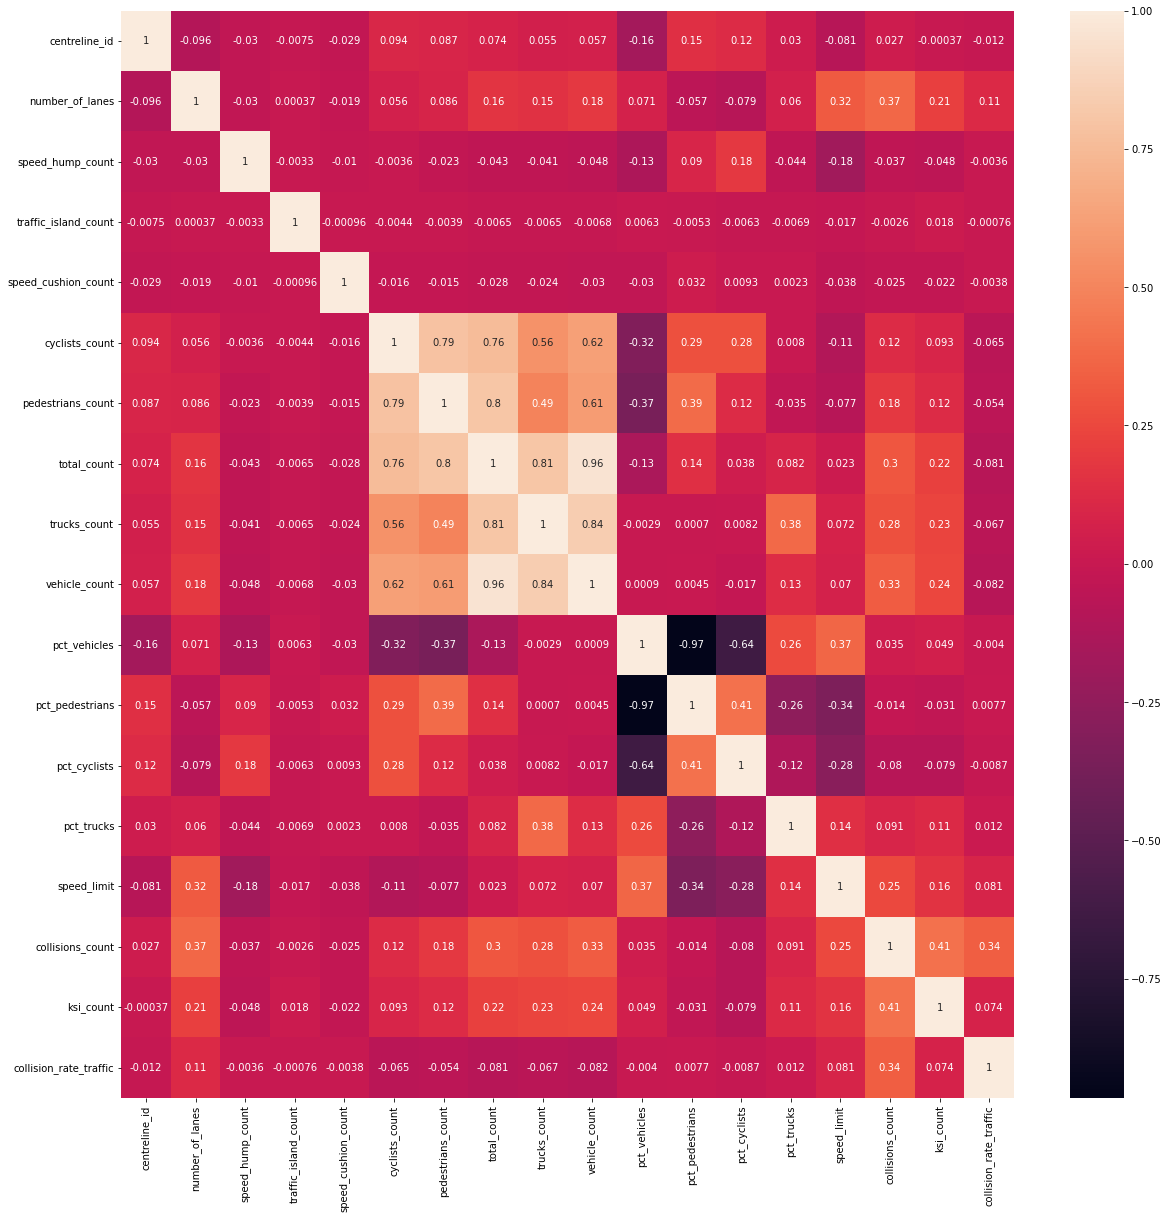

In [239]:
#heatmap of feature correlations
plt.figure(figsize=(20,20))
sns.heatmap(final_df.corr(), annot=True)

In [240]:
#set centreline id as index
final_df = final_df.set_index('centreline_id')

#drop unneccesary columns
final_df = final_df.drop(columns=['road_name','geometry','pct_pedestrians','pct_cyclists','pct_trucks','pct_vehicles','ksi_count','speed_cushion_count','traffic_island_count','speed_hump_count','total_count','road_hierarchy'])

In [241]:
final_df.head()

,road_classification,bikelane_present,number_of_lanes,pedestrian_crossover_present,speed_enforcement_present,cyclists_count,pedestrians_count,trucks_count,vehicle_count,traffic_cameras_present,speed_limit,sensitive_zone,collisions_count,collision_rate_traffic,collision_class,speed_hump_present
centreline_id,,,,,,,,,,,,,,,,
914587,Major Arterial,No,2,No,No,10,792,122,7573,No,30,Yes,7.0,0.835821,5-20,NO
6735911,Major Arterial,No,2,No,No,10,792,122,7573,No,30,Yes,24.0,2.865672,20-50,NO
914588,Local,Yes,2,Yes,No,10,792,122,7573,No,50,Yes,1.0,0.119403,<5,NO
9950476,Major Arterial,Yes,2,No,No,13,961,338,12341,No,50,No,76.0,5.707848,50-80,NO
3135620,Major Arterial,No,2,No,No,45,68,549,12426,No,50,Yes,5.0,0.398756,5-20,NO


In [242]:
#setting data types for variables

#setting data types to category
final_df[['road_classification','collision_class','bikelane_present','pedestrian_crossover_present','speed_enforcement_present','traffic_cameras_present','sensitive_zone','speed_hump_present']] = final_df[['road_classification','collision_class','bikelane_present','pedestrian_crossover_present','speed_enforcement_present','traffic_cameras_present','sensitive_zone','speed_hump_present']].astype('category')

#setting data types to integer
final_df[['collisions_count','number_of_lanes']] = final_df[['collisions_count','number_of_lanes']].astype('int64')

# Data Processing

## Checking Skews and Outliers

In [243]:
dtale.show(final_df)

d:\Software\Anaconda\lib\site-packages\dtale\views.py:756: FutureWarning:

['road_classification', 'bikelane_present', 'pedestrian_crossover_present', 'speed_enforcement_present', 'traffic_cameras_present', 'sensitive_zone', 'collision_class', 'speed_hump_present'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.



In [244]:
final_df.skew()

C:\Users\arara\AppData\Local\Temp\ipykernel_57968\1869444327.py:1: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



number_of_lanes            0.849748
cyclists_count             7.360736
pedestrians_count          9.977515
trucks_count               4.593409
vehicle_count              4.349662
speed_limit                1.217062
collisions_count           4.322991
collision_rate_traffic    25.347762
dtype: float64

### Cap and Floor

Collision Rate

In [245]:
final_df.collision_rate_traffic.describe()

count    7986.000000
mean        2.839036
std         8.647943
min         0.000000
25%         0.344003
50%         1.199082
75%         2.919239
max       383.529412
Name: collision_rate_traffic, dtype: float64

In [246]:
final_df[final_df['collision_rate_traffic'] > 10].shape

(376, 16)

In [247]:
#capping collision rate to 50, which only affects 376/7986 rows
final_df['collision_rate_traffic'] = final_df['collision_rate_traffic'].clip(0,10)

<AxesSubplot:xlabel='collision_rate_traffic'>

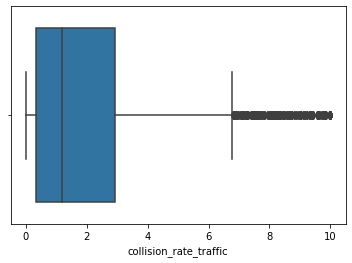

In [248]:
sns.boxplot(x='collision_rate_traffic',data=final_df)

Collisions Count

In [249]:
final_df.collisions_count.describe()

count    7986.000000
mean       43.746932
std        92.159074
min         0.000000
25%         3.000000
50%        10.000000
75%        39.000000
max      1064.000000
Name: collisions_count, dtype: float64

In [250]:
#capping collisions count 150, which only affects 615/7986 rows
final_df['collisions_count'] = final_df['collisions_count'].clip(0,150)

<AxesSubplot:xlabel='collisions_count'>

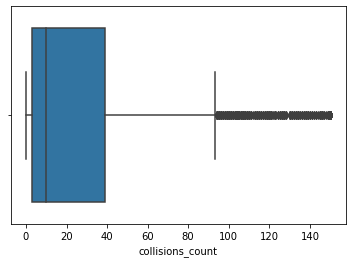

In [251]:
#still quite a few outliers
sns.boxplot(x='collisions_count',data=final_df)

Vehicle Count

count      7986.000000
mean      22166.630353
std       35783.419902
min          95.000000
25%        4603.000000
50%       11004.000000
75%       22712.500000
max      412989.000000
Name: vehicle_count, dtype: float64


<AxesSubplot:>

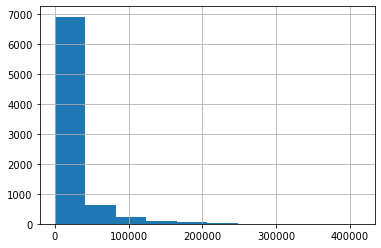

In [252]:
print(final_df.vehicle_count.describe())
final_df.vehicle_count.hist()

<AxesSubplot:xlabel='vehicle_count'>

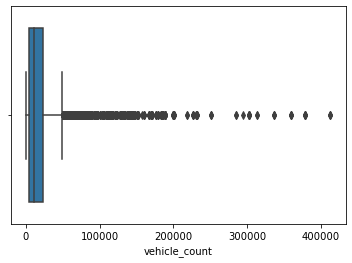

In [253]:
sns.boxplot(x='vehicle_count',data=final_df)

In [254]:
#clipping vehicle count to 75000 using 3IQR range, which only affects 519/7986 rows
final_df['vehicle_count'] = final_df['vehicle_count'].clip(0,75000)

Trucks Count

count     7986.000000
mean       879.546081
std       1781.897633
min          0.000000
25%         78.000000
50%        292.000000
75%        801.000000
max      21004.000000
Name: trucks_count, dtype: float64


<AxesSubplot:>

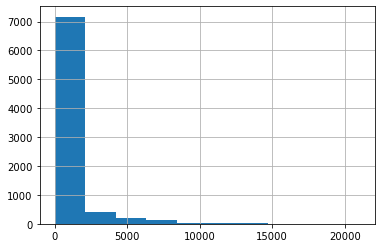

In [255]:
print(final_df.trucks_count.describe())
final_df.trucks_count.hist()

<AxesSubplot:xlabel='trucks_count'>

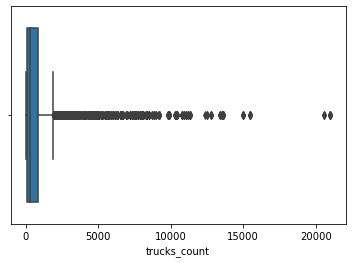

In [256]:
sns.boxplot(x='trucks_count',data=final_df)

In [257]:
final_df[final_df['trucks_count'] > 5000].shape

(306, 16)

In [258]:
#clipping trucks count to 3000 using 3IQR range, which only affects 550/7986 rows
final_df['trucks_count'] = final_df['trucks_count'].clip(0,3000)

Pedestrian Count

In [259]:
final_df.pedestrians_count.describe()

count      7986.000000
mean       4399.901578
std       15119.874634
min           0.000000
25%         226.000000
50%         640.000000
75%        2125.000000
max      330325.000000
Name: pedestrians_count, dtype: float64

<AxesSubplot:xlabel='trucks_count'>

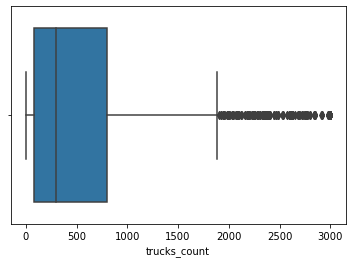

In [260]:
sns.boxplot(x='trucks_count',data=final_df)

In [261]:
final_df[final_df['pedestrians_count'] > 10000].shape

(730, 16)

In [262]:
#clipping pedestrian count to 10000 using 3IQR range, which only affects 730/7986 rows
final_df['pedestrians_count'] = final_df['pedestrians_count'].clip(0,10000)

Cyclists Count

<AxesSubplot:xlabel='cyclists_count'>

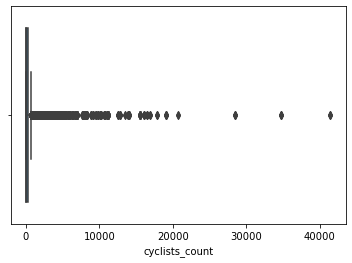

In [263]:
sns.boxplot(x='cyclists_count',data=final_df)

In [264]:
final_df.cyclists_count.describe()

count     7986.000000
mean       692.115577
std       2343.399708
min          0.000000
25%          8.000000
50%         40.500000
75%        270.000000
max      41430.000000
Name: cyclists_count, dtype: float64

In [265]:
final_df[final_df['cyclists_count'] > 2000].shape

(631, 16)

In [266]:
#clipping cyclists count to 2000, which only affects 631/7986 rows
final_df['cyclists_count'] = final_df['cyclists_count'].clip(0,2000)

Total Count

In [267]:
#final_df.total_count.describe()

In [268]:
#final_df.total_count.quantile(0.75) - final_df.total_count.quantile(0.25)

In [269]:
#final_df[final_df['total_count'] < 1000].shape

In [270]:
#clipping total count to 100,0000, which only affects 499/7986 rows
#final_df['total_count'] = final_df['total_count'].clip(0,100000)

### Log Transformation

Log Transformation was chosen as the data is mostly right-skewed and has outliers. 0 values in the columns are replaced with 1.

In [271]:
#applying log transformation on the numerical variables. variables that have a value of 0 are replaced with 1 before applying log transformation.
def log_transform(x):
    return np.log2(x+1)

final_df[['cyclists_count','pedestrians_count','trucks_count','vehicle_count','speed_limit','collisions_count','collision_rate_traffic','number_of_lanes']] = final_df[['cyclists_count','pedestrians_count','trucks_count','vehicle_count','speed_limit','collisions_count','collision_rate_traffic','number_of_lanes']].apply(log_transform)

# Regression Models

In [41]:
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error


In [1]:
#creating a function to return regression summary
def regression_summary(model):
    print('Regression Statistics:\n')
    print(f'Mean Squared Error (MSE): {mean_squared_error(valid_y,model.predict(valid_X))}')
    print(f'Mean Absolute Error (MAE): {mean_absolute_error(valid_y,model.predict(valid_X))}')
    print(f'Mean Absolute Percentage Error (MAPE): {mean_absolute_percentage_error(valid_y,model.predict(valid_X))}')
    print(f'Normalized MAE:{mean_absolute_error(valid_y,model.predict(valid_X))/(valid_y.max()-valid_y.min())}')

## With Volume - Collisions Count

### Train/Test Splits + Sampling

In [43]:
#specifying predictors and outcome
excluded_columns = ['collision_class','collision_rate_traffic']
outcome = ['collisions_count']
predictors = [s for s in final_df.columns if s not in outcome + excluded_columns]

#splitting predictors and outcome into X and y dataframes
X = pd.get_dummies(final_df[predictors],drop_first=True)
y = final_df[outcome]

#splitting data into train and test
from sklearn.model_selection import train_test_split
train_X,valid_X,train_y,valid_y = train_test_split(X,y,test_size=0.3,random_state=1)

### Model 1 - Decision Tree Regressor

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

#setting parameter grid
param_grid ={'max_depth':[2,4,6,8,10,],'min_samples_split':[1,2,4,6],'min_samples_leaf':[8,10,12,14,16]}

#fitting grid search model
model_1 = GridSearchCV(DecisionTreeRegressor(random_state=1),param_grid,cv=5,n_jobs=-1)
model_1.fit(train_X,train_y)

In [45]:
model_1.best_params_

{'max_depth': 6, 'min_samples_leaf': 14, 'min_samples_split': 2}

In [46]:
regression_summary(model_1)

Regression Statistics:

Mean Squared Error (MSE): 2.4331449310336284
Mean Absolute Error (MAE): 1.1937494987268837
Mean Absolute Percentage Error (MAPE): 845199550860925.1
MAE/Target Range:collisions_count    0.164919
dtype: float64


In [47]:
#looking at residuals for model_1
residuals_df_1 = pd.DataFrame({'actual':valid_y['collisions_count'],'predicted':model_1.predict(valid_X),'residual':valid_y['collisions_count']-model_1.predict(valid_X)})
residuals_df_1

,actual,predicted,residual
centreline_id,,,
8313000,1.000000,2.628063,-1.628063
14013581,4.392317,2.217132,2.175185
1145090,7.189825,6.285631,0.904194
439663,6.930737,6.878403,0.052335
8166223,3.169925,4.960202,-1.790277
...,...,...,...
14037166,7.149747,6.285631,0.864116
444176,0.000000,2.217132,-2.217132
5336642,6.303781,4.663718,1.640063


<AxesSubplot:>

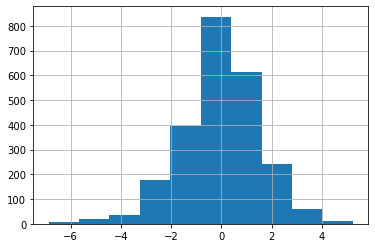

In [48]:
#residuals are normally distributed
residuals_df_1.residual.hist()

C:\Users\arara\AppData\Local\Temp\ipykernel_57968\4276788285.py:4: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



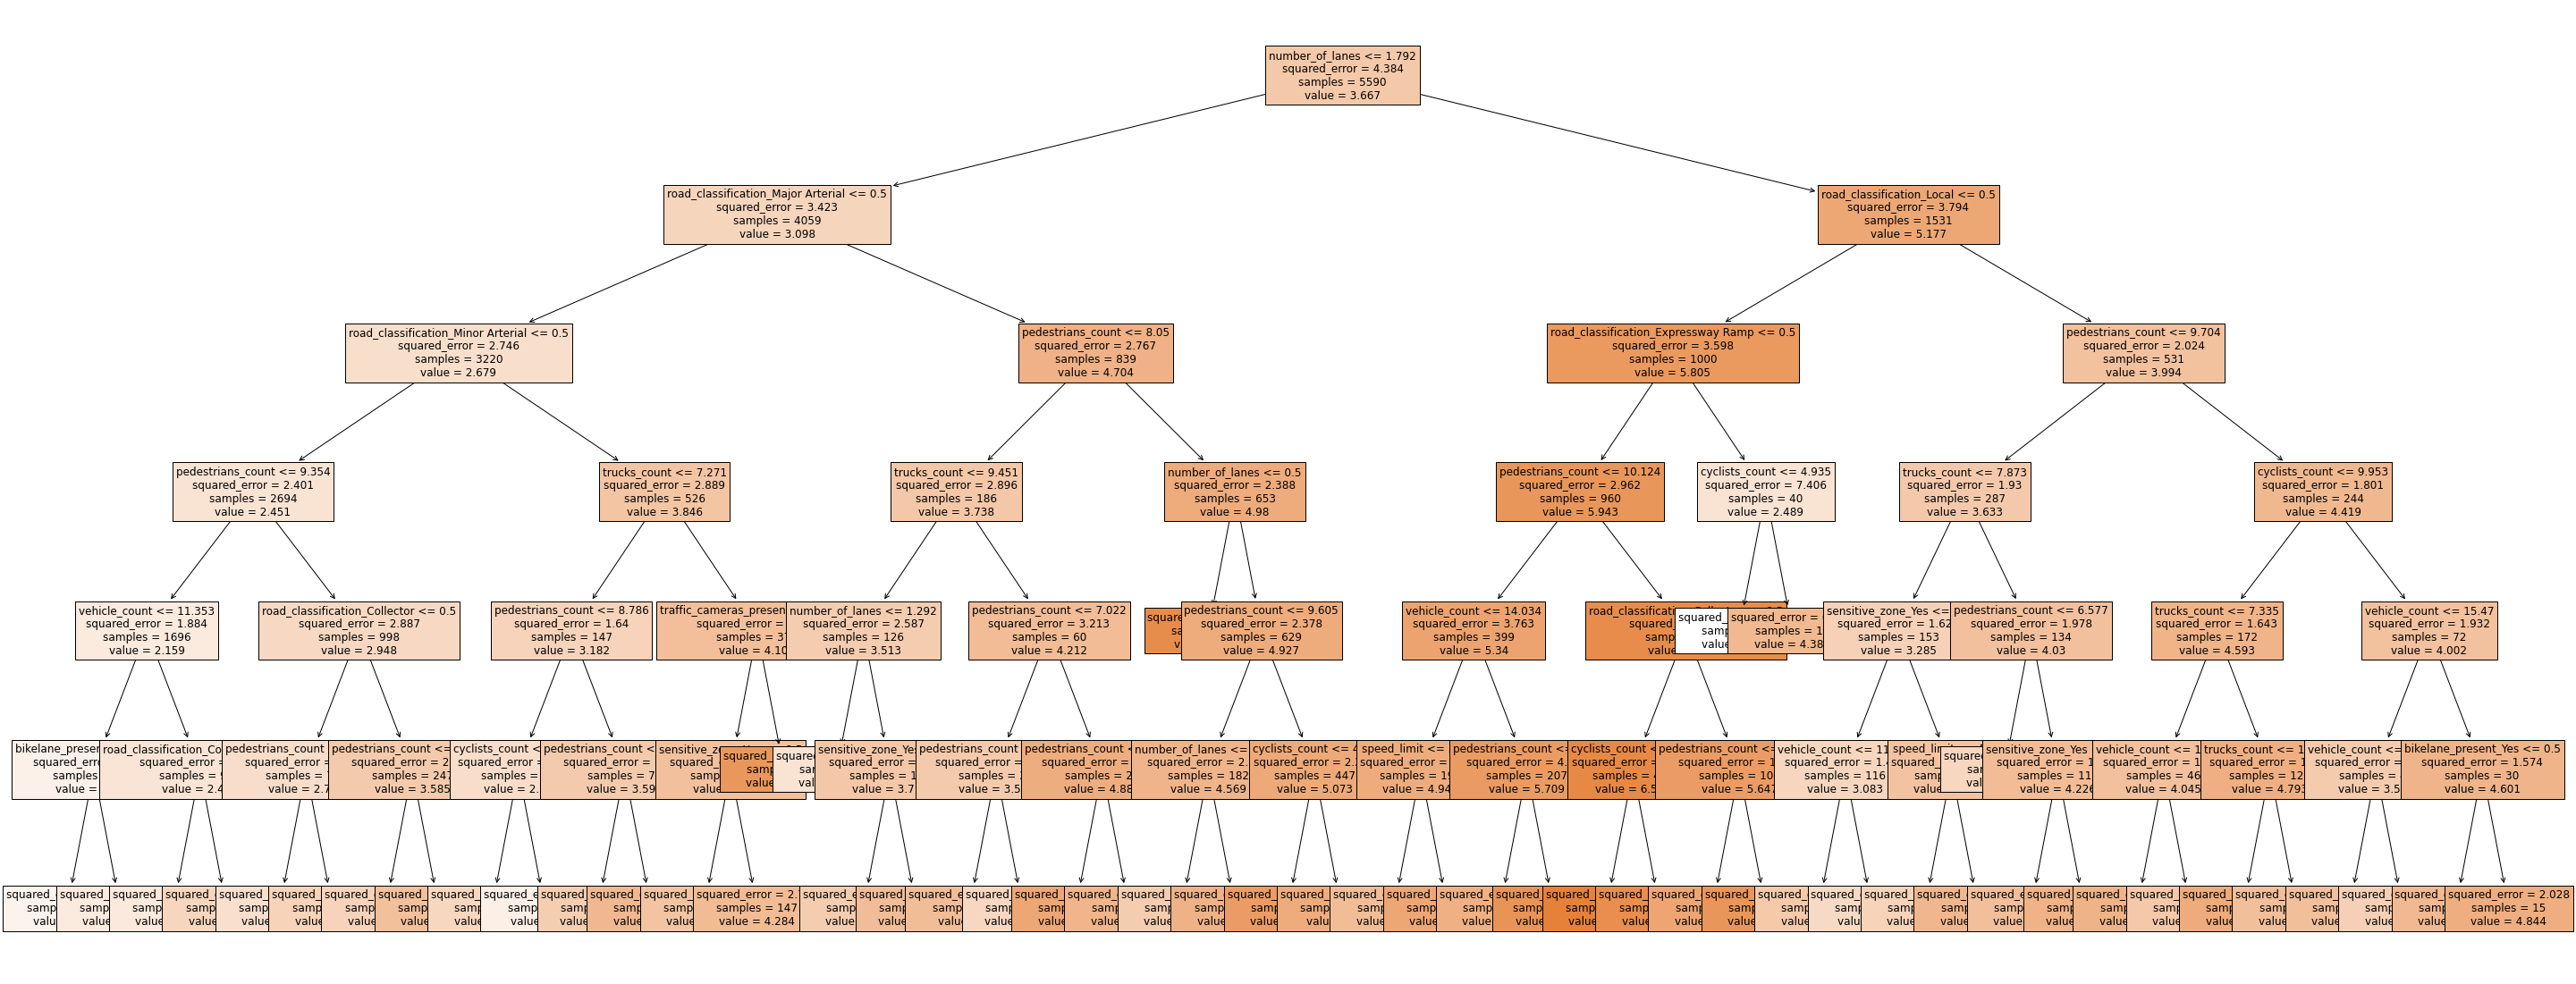

In [49]:
from sklearn.tree import plot_tree
fig,ax = plt.subplots(figsize=(50,20))
plot_tree(model_1.best_estimator_,filled=True,fontsize=12,feature_names=train_X.columns)
fig.show()

### Model 2 - Random Forest Regressor

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

#setting parameter grid
param_grid ={'max_depth':[8,10,12,14],'min_samples_split':[1,2,4],'min_samples_leaf':[2,4,6],'n_estimators':[50,80,100]}

#fitting grid search model
model_2 = GridSearchCV(RandomForestRegressor(random_state=1,bootstrap=True),param_grid,cv=5,n_jobs=-1)
model_2.fit(train_X,train_y)

In [51]:
model_2.best_params_

{'max_depth': 10,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 100}

In [52]:
regression_summary(model_2)

Regression Statistics:

Mean Squared Error (MSE): 2.1461851710564708
Mean Absolute Error (MAE): 1.1097011207527647
Mean Absolute Percentage Error (MAPE): 765030033980776.5
MAE/Target Range:collisions_count    0.153307
dtype: float64


In [53]:
#looking at residuals for model_2
residuals_df_2 = pd.DataFrame({'actual':valid_y['collisions_count'],'predicted':model_2.predict(valid_X),'residual':valid_y['collisions_count']-model_2.predict(valid_X)})
residuals_df_2

,actual,predicted,residual
centreline_id,,,
8313000,1.000000,2.415696,-1.415696
14013581,4.392317,2.183748,2.208569
1145090,7.189825,6.274404,0.915421
439663,6.930737,6.308062,0.622676
8166223,3.169925,5.336672,-2.166747
...,...,...,...
14037166,7.149747,6.574627,0.575120
444176,0.000000,2.231363,-2.231363
5336642,6.303781,4.507131,1.796650


<AxesSubplot:>

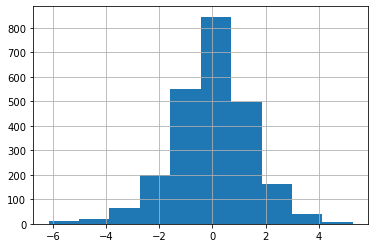

In [54]:
#residuals normally distributed 
residuals_df_2.residual.hist()

In [55]:
feature_importance_model_2 = pd.DataFrame({'coef':model_2.best_estimator_.feature_importances_,'predictors':train_X.columns}).sort_values(by='coef',ascending=False).sort_values(by='coef',ascending=False)
feature_importance_model_2.head(10)

,coef,predictors
0,0.284604,number_of_lanes
11,0.150011,road_classification_Local
12,0.128891,road_classification_Major Arterial
2,0.121753,pedestrians_count
4,0.064455,vehicle_count
1,0.057263,cyclists_count
3,0.055174,trucks_count
14,0.033745,road_classification_Minor Arterial
10,0.030557,road_classification_Expressway Ramp
5,0.023539,speed_limit


## Without Volume - Collisions Count

Modeling without Traffic Volumes to see which features show up in the absence of volume data.

### Train/Test Splits + Sampling

In [56]:
final_df.columns

Index(['road_classification', 'bikelane_present', 'number_of_lanes',
       'pedestrian_crossover_present', 'speed_enforcement_present',
       'cyclists_count', 'pedestrians_count', 'trucks_count', 'vehicle_count',
       'traffic_cameras_present', 'speed_limit', 'sensitive_zone',
       'collisions_count', 'collision_rate_traffic', 'collision_class',
       'speed_hump_present'],
      dtype='object')

In [57]:
#specifying predictors and outcome
excluded_columns = ['collision_class','collision_rate_traffic','total_count','trucks_count','vehicle_count','cyclists_count','pedestrians_count']
outcome = ['collisions_count']
predictors = [s for s in final_df.columns if s not in outcome + excluded_columns]

#splitting predictors and outcome into X and y dataframes
X = pd.get_dummies(final_df[predictors],drop_first=True)
y = final_df[outcome]

#splitting data into train and test
from sklearn.model_selection import train_test_split
train_X,valid_X,train_y,valid_y = train_test_split(X,y,test_size=0.3,random_state=1)

### Model 3 - Random Forest Regressor

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

#setting parameter grid
param_grid ={'max_depth':[4,6,8,10],'min_samples_split':[1,2,4],'min_samples_leaf':[1,2,4,6],'n_estimators':[100,200,300,400]}

#fitting grid search model
model_3 = GridSearchCV(RandomForestRegressor(random_state=1,bootstrap=True),param_grid,cv=5,n_jobs=-1)
model_3.fit(train_X,train_y)

In [59]:
model_3.best_params_

{'max_depth': 8,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 400}

In [60]:
regression_summary(model_3)

Regression Statistics:

Mean Squared Error (MSE): 2.3332155336522162
Mean Absolute Error (MAE): 1.1710732352940438
Mean Absolute Percentage Error (MAPE): 794572185130750.8
MAE/Target Range:collisions_count    0.161786
dtype: float64


In [61]:
final_df.collisions_count.describe()

count    7986.000000
mean        3.654934
std         2.097061
min         0.000000
25%         2.000000
50%         3.459432
75%         5.321928
max         7.238405
Name: collisions_count, dtype: float64

In [62]:
#looking at residuals for model_3
residuals_df_3 = pd.DataFrame({'actual':valid_y['collisions_count'],'predicted':model_3.predict(valid_X),'residual':valid_y['collisions_count']-model_3.predict(valid_X)})
residuals_df_3

,actual,predicted,residual
centreline_id,,,
8313000,1.000000,2.066597,-1.066597
14013581,4.392317,2.066597,2.325721
1145090,7.189825,6.178044,1.011780
439663,6.930737,6.392560,0.538178
8166223,3.169925,4.901247,-1.731322
...,...,...,...
14037166,7.149747,6.220835,0.928912
444176,0.000000,1.435659,-1.435659
5336642,6.303781,4.149922,2.153859


<AxesSubplot:>

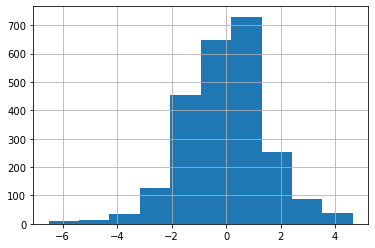

In [63]:
#residuals normally distributed 
residuals_df_3.residual.hist()

In [64]:
feature_importance_model_3 = pd.DataFrame({'coef':model_3.best_estimator_.feature_importances_,'predictors':train_X.columns}).sort_values(by='coef',ascending=False).sort_values(by='coef',ascending=False)
feature_importance_model_3.head()

,coef,predictors
0,0.376320,number_of_lanes
7,0.205459,road_classification_Local
8,0.157570,road_classification_Major Arterial
10,0.047067,road_classification_Minor Arterial
1,0.046792,speed_limit


## With Volume - Collision Rate

### Train/Test Splits + Sampling

In [65]:
#specifying predictors and outcome
excluded_columns = ['collision_class','collisions_count']
outcome = ['collision_rate_traffic']
predictors = [s for s in final_df.columns if s not in outcome + excluded_columns]

#splitting predictors and outcome into X and y dataframes
X = pd.get_dummies(final_df[predictors],drop_first=True)
y = final_df[outcome]

#splitting data into train and test
from sklearn.model_selection import train_test_split
train_X,valid_X,train_y,valid_y = train_test_split(X,y,test_size=0.3,random_state=1)

### Model 4 - Random Forest Regressor

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

#setting parameter grid
param_grid ={'max_depth':[10,12,14],'min_samples_split':[1,2,4],'min_samples_leaf':[1,2,4,6],'n_estimators':[800]}

#fitting grid search model
model_4 = GridSearchCV(RandomForestRegressor(random_state=1,bootstrap=True),param_grid,cv=5,n_jobs=-1)
model_4.fit(train_X,train_y)

In [67]:
model_4.best_params_

{'max_depth': 12,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 800}

In [68]:
regression_summary(model_4)

Regression Statistics:

Mean Squared Error (MSE): 0.5911218837983653
Mean Absolute Error (MAE): 0.5873730036564754
Mean Absolute Percentage Error (MAPE): 301991510536521.4
MAE/Target Range:collision_rate_traffic    0.169789
dtype: float64


In [69]:
#looking at residuals for model_4
residuals_df_4 = pd.DataFrame({'actual':valid_y['collision_rate_traffic'],'predicted':model_4.predict(valid_X),'residual':valid_y['collision_rate_traffic']-model_4.predict(valid_X)})
residuals_df_4

,actual,predicted,residual
centreline_id,,,
8313000,0.130437,0.549583,-0.419146
14013581,1.530536,0.462751,1.067784
1145090,0.731152,0.667477,0.063675
439663,2.669653,2.343972,0.325681
8166223,0.619056,2.184485,-1.565429
...,...,...,...
14037166,1.779472,1.411017,0.368456
444176,0.000000,0.512403,-0.512403
5336642,2.015240,1.243323,0.771917


<AxesSubplot:>

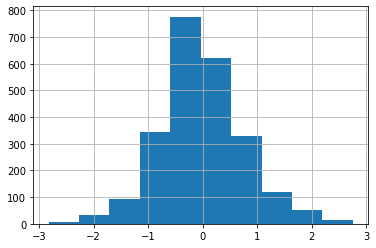

In [70]:
#residuals normally distributed 
residuals_df_4.residual.hist()

In [71]:
feature_importance_model_4 = pd.DataFrame({'coef':model_4.best_estimator_.feature_importances_,'predictors':train_X.columns}).sort_values(by='coef',ascending=False).sort_values(by='coef',ascending=False)
feature_importance_model_4.head()

,coef,predictors
4,0.313689,vehicle_count
1,0.132063,cyclists_count
2,0.113939,pedestrians_count
0,0.113149,number_of_lanes
3,0.086676,trucks_count


### Add Model 1 - Neural Network Regressor

In [72]:
#setting parameter grid
param_grid = {'hidden_layer_sizes': [8,10,12],'solver':['lbfgs','adam'],'activation':['relu','logistic','tanh']}

add_model_1 = GridSearchCV(MLPRegressor(random_state=1,max_iter=10000),param_grid,cv=5,n_jobs=-1)
add_model_1.fit(train_X,train_y)

d:\Software\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1599: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



GridSearchCV(cv=5, estimator=MLPRegressor(max_iter=10000, random_state=1),
             n_jobs=-1,
             param_grid={'activation': ['relu', 'logistic', 'tanh'],
                         'hidden_layer_sizes': [8, 10, 12],
                         'solver': ['lbfgs', 'adam']})

In [73]:
add_model_1.best_params_

{'activation': 'tanh', 'hidden_layer_sizes': 12, 'solver': 'adam'}

In [76]:
regression_summary(add_model_1)

Regression Statistics:

Mean Squared Error (MSE): 0.6132829439906284
Mean Absolute Error (MAE): 0.604081702999329
Mean Absolute Percentage Error (MAPE): 287371321505858.2
MAE/Target Range:collision_rate_traffic    0.174619
dtype: float64


### Add Model 2 - AdaBoost Regressor

In [78]:
#setting parameter grid
param_grid ={'n_estimators':[10,20,30,50,80]}

#fitting grid search model
add_model_2 = GridSearchCV(AdaBoostRegressor(random_state=1),param_grid,cv=5,n_jobs=-1)
add_model_2.fit(train_X,train_y)

d:\Software\Anaconda\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



GridSearchCV(cv=5, estimator=AdaBoostRegressor(random_state=1), n_jobs=-1,
             param_grid={'n_estimators': [10, 20, 30, 50, 80]})

In [79]:
add_model_2.best_params_

{'n_estimators': 10}

In [80]:
regression_summary(add_model_2)

Regression Statistics:

Mean Squared Error (MSE): 0.7723108602398425
Mean Absolute Error (MAE): 0.7289714093369668
Mean Absolute Percentage Error (MAPE): 404741714542612.3
MAE/Target Range:collision_rate_traffic    0.21072
dtype: float64


In [81]:
feature_importance_add_model_2 = pd.DataFrame({'coef':add_model_2.best_estimator_.feature_importances_,'predictors':train_X.columns}).sort_values(by='coef',ascending=False).sort_values(by='coef',ascending=False)
feature_importance_add_model_2.head()

,coef,predictors
4,0.356126,vehicle_count
0,0.209903,number_of_lanes
1,0.165084,cyclists_count
11,0.089481,road_classification_Local
12,0.057072,road_classification_Major Arterial


### Add Model 3 - Linear Regression

In [82]:
add_model_3 = LinearRegression(n_jobs=-1)
add_model_3.fit(train_X,train_y)

LinearRegression(n_jobs=-1)

In [83]:
regression_summary(add_model_3)

Regression Statistics:

Mean Squared Error (MSE): 0.6758081231768986
Mean Absolute Error (MAE): 0.6535975259287684
Mean Absolute Percentage Error (MAPE): 294316230142221.56
MAE/Target Range:collision_rate_traffic    0.188932
dtype: float64


In [84]:
feature_importance_add_model_3 = pd.DataFrame({'coef':add_model_3.coef_[0],'predictors':train_X.columns}).sort_values(by='coef',ascending=False).sort_values(by='coef',ascending=False)
feature_importance_add_model_3.head()

,coef,predictors
12,0.796222,road_classification_Major Arterial
14,0.613611,road_classification_Minor Arterial
9,0.491620,road_classification_Expressway
0,0.472320,number_of_lanes
20,0.423942,traffic_cameras_present_Yes


### Add Model 4 - XGBoost [Best Overall Regression Model]

In [85]:
#setting parameter grid
param_grid ={'max_depth':[1,2,3,4,6],'learning_rate':[0.1,0.01,0.001,0.2],'n_estimators':[100,150,200,300,400]}

#fitting xgboost model
add_model_4 = xgb.XGBRegressor(random_state=1)
add_model_4.fit(train_X,train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=1, ...)

In [86]:
regression_summary(add_model_4)

Regression Statistics:

Mean Squared Error (MSE): 0.5766868238117391
Mean Absolute Error (MAE): 0.5669784756049971
Mean Absolute Percentage Error (MAPE): 268310550516157.44
MAE/Target Range:collision_rate_traffic    0.163894
dtype: float64


In [87]:
#looking at residuals for model_4
residuals_df_add_1 = pd.DataFrame({'actual':valid_y['collision_rate_traffic'],'predicted':add_model_4.predict(valid_X),'residual':valid_y['collision_rate_traffic']-add_model_4.predict(valid_X)})
residuals_df_add_1

,actual,predicted,residual
centreline_id,,,
8313000,0.130437,0.406194,-0.275757
14013581,1.530536,-0.090922,1.621458
1145090,0.731152,0.457617,0.273535
439663,2.669653,2.469517,0.200137
8166223,0.619056,2.813519,-2.194463
...,...,...,...
14037166,1.779472,1.256746,0.522727
444176,0.000000,0.849712,-0.849712
5336642,2.015240,1.335577,0.679663


<AxesSubplot:>

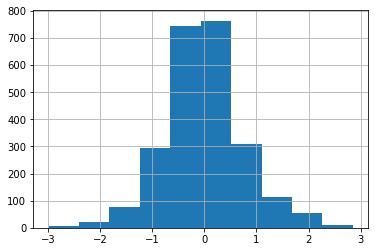

In [286]:
residuals_df_add_1.residual.hist()

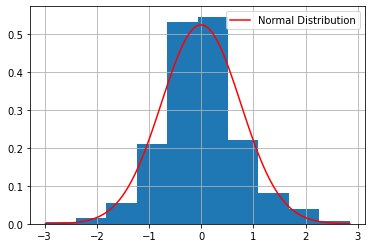

In [287]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Plot histogram
residuals_df_add_1.residual.hist(density=True)

# Calculate mean and standard deviation
mean = residuals_df_add_1.residual.mean()
std_dev = residuals_df_add_1.residual.std()

# Create an array of values for the x-axis 
x = np.linspace(residuals_df_add_1.residual.min(), residuals_df_add_1.residual.max(), 100)

# Generate normal distribution PDF
pdf = norm.pdf(x, mean, std_dev)

# Plot normal distribution line
plt.plot(x, pdf, color='red', label='Normal Distribution')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [89]:
feature_importance_add_model_4 = pd.DataFrame({'coef':add_model_4.feature_importances_,'predictors':train_X.columns}).sort_values(by='coef',ascending=False).sort_values(by='coef',ascending=False)
feature_importance_add_model_4.head()

,coef,predictors
10,0.115145,road_classification_Expressway Ramp
11,0.102791,road_classification_Local
12,0.099045,road_classification_Major Arterial
20,0.098958,traffic_cameras_present_Yes
8,0.092863,road_classification_Collector Ramp


In [288]:
feature_importance_add_model_4.head(10)

,coef,predictors
10,0.115145,road_classification_Expressway Ramp
11,0.102791,road_classification_Local
12,0.099045,road_classification_Major Arterial
20,0.098958,traffic_cameras_present_Yes
8,0.092863,road_classification_Collector Ramp
4,0.081711,vehicle_count
0,0.051327,number_of_lanes
14,0.045857,road_classification_Minor Arterial
21,0.035323,sensitive_zone_Yes
2,0.032345,pedestrians_count


In [297]:
add_model_4.coef_

AttributeError: Coefficients are not defined for Booster type None

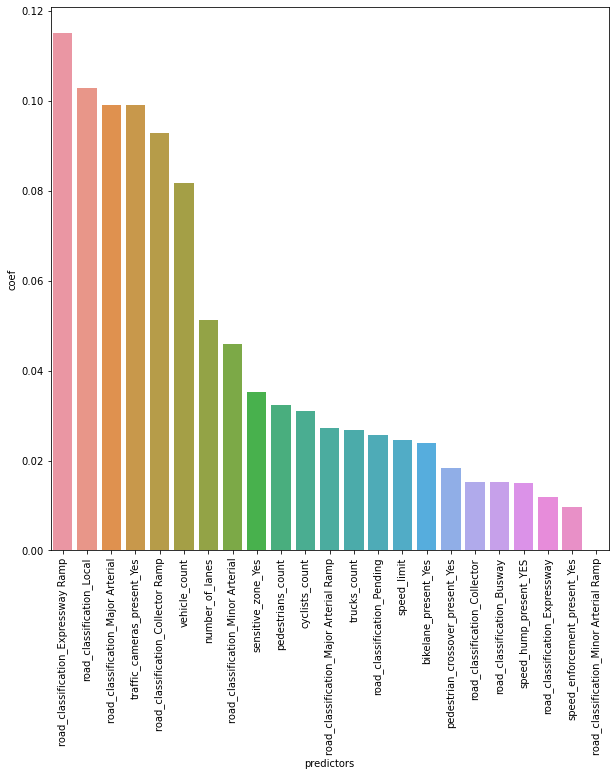

In [228]:
#plotting road_classification versus collision rate
plt.figure(figsize=(10,10))
sns.barplot(x=feature_importance_add_model_4.predictors,y=feature_importance_add_model_4.coef)
plt.xticks(rotation=90) # Rotate x tick labels by 90 degrees

plt.show()

## Without Volume - Collision Rate

### Train/Test Splits + Sampling

In [90]:
#specifying predictors and outcome
excluded_columns = ['collision_class','total_count','trucks_count','vehicle_count','cyclists_count','pedestrians_count','collisions_count']
outcome = ['collision_rate_traffic']
predictors = [s for s in final_df.columns if s not in outcome + excluded_columns]

#splitting predictors and outcome into X and y dataframes
X = pd.get_dummies(final_df[predictors],drop_first=True)
y = final_df[outcome]

#splitting data into train and test
from sklearn.model_selection import train_test_split
train_X,valid_X,train_y,valid_y = train_test_split(X,y,test_size=0.3,random_state=1)

### Model 5 - Random Forest Regressor [Best Base Regression Model]

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

#setting parameter grid
param_grid ={'max_depth':[10,12,14],'min_samples_split':[1,2,4],'min_samples_leaf':[1,2,4,6],'n_estimators':[600,800,1000]}

#fitting grid search model
model_5 = GridSearchCV(RandomForestRegressor(random_state=1,bootstrap=True),param_grid,cv=5,n_jobs=-1)
model_5.fit(train_X,train_y)

In [92]:
model_5.best_params_

{'max_depth': 10,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 600}

In [93]:
regression_summary(model_5)

Regression Statistics:

Mean Squared Error (MSE): 0.8870989106457856
Mean Absolute Error (MAE): 0.7734012498966811
Mean Absolute Percentage Error (MAPE): 294060853716347.0
MAE/Target Range:collision_rate_traffic    0.223563
dtype: float64


In [94]:
#feature importances for model 5
feature_importance_model_5 = pd.DataFrame({'coef':model_5.best_estimator_.feature_importances_,'predictors':train_X.columns}).sort_values(by='coef',ascending=False).sort_values(by='coef',ascending=False)
feature_importance_model_5.head()

,coef,predictors
0,0.384530,number_of_lanes
1,0.135196,speed_limit
7,0.079134,road_classification_Local
13,0.067782,bikelane_present_Yes
6,0.061004,road_classification_Expressway Ramp


In [289]:
feature_importance_model_5.head(10)

,coef,predictors
0,0.384530,number_of_lanes
1,0.135196,speed_limit
7,0.079134,road_classification_Local
13,0.067782,bikelane_present_Yes
6,0.061004,road_classification_Expressway Ramp
8,0.060379,road_classification_Major Arterial
17,0.052633,sensitive_zone_Yes
16,0.048442,traffic_cameras_present_Yes
3,0.030495,road_classification_Collector
18,0.020123,speed_hump_present_YES


### Add Model 5 - Neural Network Regressor

In [95]:
#setting parameter grid
param_grid = {'hidden_layer_sizes': [8,10,12],'solver':['lbfgs','adam'],'activation':['relu','logistic','tanh']}

add_model_5 = GridSearchCV(MLPRegressor(random_state=1,max_iter=10000),param_grid,cv=5,n_jobs=-1)
add_model_5.fit(train_X,train_y)

d:\Software\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1599: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



GridSearchCV(cv=5, estimator=MLPRegressor(max_iter=10000, random_state=1),
             n_jobs=-1,
             param_grid={'activation': ['relu', 'logistic', 'tanh'],
                         'hidden_layer_sizes': [8, 10, 12],
                         'solver': ['lbfgs', 'adam']})

In [96]:
add_model_5.best_params_

{'activation': 'tanh', 'hidden_layer_sizes': 8, 'solver': 'adam'}

In [97]:
regression_summary(add_model_5)

Regression Statistics:

Mean Squared Error (MSE): 0.8936948108376269
Mean Absolute Error (MAE): 0.7855813566906488
Mean Absolute Percentage Error (MAPE): 296164651261523.44
MAE/Target Range:collision_rate_traffic    0.227084
dtype: float64


### Add Model 6 - XGBoost

In [98]:
#setting parameter grid
param_grid ={'max_depth':[1,2,3,4,6],'learning_rate':[0.1,0.01,0.001,0.2],'n_estimators':[100,150,200,300,400]}

#fitting xgboost model
add_model_6 = xgb.XGBRegressor(random_state=1)
add_model_6.fit(train_X,train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=1, ...)

In [99]:
regression_summary(add_model_6)

Regression Statistics:

Mean Squared Error (MSE): 0.9185706874141408
Mean Absolute Error (MAE): 0.7758060573389658
Mean Absolute Percentage Error (MAPE): 285719088973938.9
MAE/Target Range:collision_rate_traffic    0.224258
dtype: float64


In [100]:
feature_importance_add_model_6 = pd.DataFrame({'coef':add_model_6.feature_importances_,'predictors':train_X.columns}).sort_values(by='coef',ascending=False).sort_values(by='coef',ascending=False)
feature_importance_add_model_6.head()

,coef,predictors
6,0.124704,road_classification_Expressway Ramp
7,0.116194,road_classification_Local
8,0.113479,road_classification_Major Arterial
0,0.107518,number_of_lanes
9,0.050125,road_classification_Major Arterial Ramp


In [292]:
feature_importance_add_model_6.head(10)

,coef,predictors
6,0.124704,road_classification_Expressway Ramp
7,0.116194,road_classification_Local
8,0.113479,road_classification_Major Arterial
0,0.107518,number_of_lanes
9,0.050125,road_classification_Major Arterial Ramp
3,0.049878,road_classification_Collector
1,0.046709,speed_limit
4,0.045507,road_classification_Collector Ramp
16,0.043925,traffic_cameras_present_Yes
5,0.040498,road_classification_Expressway


# Classification Models

## With Volume

### Train/Test Splits + Sampling

In [272]:
#specifying predictors and outcome
excluded_columns = ['collision_rate_traffic','collisions_count']
outcome = ['collision_class']
predictors = [s for s in final_df.columns if s not in outcome + excluded_columns]

#splitting predictors and outcome into X and y dataframes
X = pd.get_dummies(final_df[predictors],drop_first=True)
y = final_df[outcome]

#splitting data into train and test
from sklearn.model_selection import train_test_split
train_X,valid_X,train_y,valid_y = train_test_split(X,y,test_size=0.3,random_state=1)

#undersampling data
from imblearn.under_sampling import RandomUnderSampler
ros = RandomUnderSampler(random_state=1)
train_X_resampled, train_y_resampled = ros.fit_resample(train_X,train_y)

In [102]:
train_y.collision_class.value_counts()

<5       1838
5-20     1652
20-50     915
>80       812
50-80     373
Name: collision_class, dtype: int64

In [103]:
train_y_resampled.value_counts()

collision_class
20-50              373
5-20               373
50-80              373
<5                 373
>80                373
dtype: int64

### Model 6 - Random Forest Classifier

In [278]:
from sklearn.ensemble import RandomForestClassifier

#setting parameter grid
param_grid ={'max_depth':[6,8,10],'min_samples_split':[8,10,12],'min_samples_leaf':[1,2],'n_estimators':[50,80,100],'bootstrap':[False]}

#fitting grid search model
model_6 = GridSearchCV(RandomForestClassifier(random_state=1),param_grid,cv=5,n_jobs=-1)
model_6.fit(train_X,train_y)

d:\Software\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'bootstrap': [False], 'max_depth': [6, 8, 10],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [50, 80, 100]})

In [279]:
model_6.best_params_

{'bootstrap': False,
 'max_depth': 8,
 'min_samples_leaf': 2,
 'min_samples_split': 12,
 'n_estimators': 80}

In [280]:
classificationSummary(valid_y,model_6.predict(valid_X),class_names=['<5','5-20','20-50','50-80','>80'])

Confusion Matrix (Accuracy 0.5463)

       Prediction
Actual    <5  5-20 20-50 50-80   >80
    <5    97   181     0    59    62
  5-20    48   355     0   260    30
 20-50    32    46     2    20    50
 50-80    11   158     0   609    34
   >80    33    52     1    10   246


In [281]:
#feature importances for model 6
feature_importance_model_6 = pd.DataFrame({'coef':model_6.best_estimator_.feature_importances_,'predictors':train_X.columns}).sort_values(by='coef',ascending=False).sort_values(by='coef',ascending=False)
feature_importance_model_6.head()

,coef,predictors
0,0.205251,number_of_lanes
11,0.134554,road_classification_Local
4,0.117292,vehicle_count
3,0.110464,trucks_count
2,0.109508,pedestrians_count


In [290]:
feature_importance_model_6.head(10)

,coef,predictors
0,0.205251,number_of_lanes
11,0.134554,road_classification_Local
4,0.117292,vehicle_count
3,0.110464,trucks_count
2,0.109508,pedestrians_count
12,0.089964,road_classification_Major Arterial
5,0.054433,speed_limit
1,0.045229,cyclists_count
20,0.032869,traffic_cameras_present_Yes
14,0.024038,road_classification_Minor Arterial


### Add Model 7 - Neural Network Classifier

In [ ]:
#setting parameter grid
param_grid = {'hidden_layer_sizes': [8,10,12],'solver':['lbfgs','adam'],'activation':['relu','logistic','tanh']}

add_model_7 = GridSearchCV(MLPClassifier(random_state=1,max_iter=10000),param_grid,cv=5,n_jobs=-1)
add_model_7.fit(train_X_resampled,train_y_resampled)

In [109]:
add_model_7.best_params_

{'activation': 'logistic', 'hidden_layer_sizes': 10, 'solver': 'adam'}

In [110]:
classificationSummary(valid_y,add_model_7.predict(valid_X),class_names=['<5','5-20','20-50','50-80','>80'])

Confusion Matrix (Accuracy 0.4691)

       Prediction
Actual    <5  5-20 20-50 50-80   >80
    <5   121    66    86    50    76
  5-20   138   186    80   242    47
 20-50    33    10    46    19    42
 50-80    75   121    51   535    30
   >80    34    13    48    11   236


### Add Model 8 - Logistic Regression

In [ ]:
#setting parameter grid
param_grid = {'solver':['lbfgs','liblinear'],'C':[0.01,0.1,1,10,12,15,20]}

add_model_8 = GridSearchCV(LogisticRegression(random_state=1,class_weight='balanced'),param_grid,cv=5,n_jobs=-1)
add_model_8.fit(train_X_resampled,train_y_resampled)

In [112]:
add_model_8.best_params_

{'C': 1, 'solver': 'lbfgs'}

In [113]:
classificationSummary(valid_y,add_model_8.predict(valid_X),class_names=['<5','5-20','20-50','50-80','>80'])

Confusion Matrix (Accuracy 0.4512)

       Prediction
Actual    <5  5-20 20-50 50-80   >80
    <5   102    59    97    52    89
  5-20   128   157    92   254    62
 20-50    32    15    47    15    41
 50-80    77   118    52   530    35
   >80    26    10    48    13   245


<p style='color:red'>The feature importance below is of predicting each class. The one shown below is the feature importance of predicting class 1 (collisions < 5)</p>

In [ ]:
#feature importance for add model 8
feature_importance_add_model_8 = pd.DataFrame({'coef':add_model_8.best_estimator_.coef_[0],'predictors':train_X.columns}).sort_values(by='coef',ascending=False).sort_values(by='coef',ascending=False)
feature_importance_add_model_8.head()

### Add Model 9 - XGBoost

In [115]:
#need label encoder to transform classes to integer values
from sklearn.preprocessing import LabelEncoder

#fitting xgboost model
add_model_9 = xgb.XGBClassifier(random_state=1)
add_model_9.fit(train_X_resampled,LabelEncoder().fit_transform(train_y_resampled))

d:\Software\Anaconda\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [116]:
classificationSummary(LabelEncoder().fit_transform(valid_y),add_model_9.predict(valid_X),class_names=['<5','5-20','20-50','50-80','>80'])

Confusion Matrix (Accuracy 0.4733)

       Prediction
Actual    <5  5-20 20-50 50-80   >80
    <5   159    76    86    35    43
  5-20   134   245    75   200    39
 20-50    32     8    76    10    24
 50-80    91   209    45   435    32
   >80    34    16    61    12   219


In [117]:
feature_importance_add_model_9 = pd.DataFrame({'coef':add_model_9.feature_importances_,'predictors':train_X.columns}).sort_values(by='coef',ascending=False).sort_values(by='coef',ascending=False)
feature_importance_add_model_9.head()

,coef,predictors
11,0.190203,road_classification_Local
0,0.101655,number_of_lanes
20,0.062931,traffic_cameras_present_Yes
4,0.051138,vehicle_count
7,0.050739,road_classification_Collector


### Add Model 10 - KNN Classifier

In [118]:
# Define the parameter grid for GridSearchCV
param_grid = {'n_neighbors': [12,15,18,20,25],
              'weights': ['uniform', 'distance']}

# Run GridSearchCV to find the best hyperparameters
add_model_10 = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, n_jobs=-1)
add_model_10.fit(train_X_resampled,train_y_resampled)

d:\Software\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [12, 15, 18, 20, 25],
                         'weights': ['uniform', 'distance']})

In [119]:
add_model_10.best_params_

{'n_neighbors': 25, 'weights': 'distance'}

In [120]:
classificationSummary(valid_y,add_model_10.predict(valid_X),class_names=['<5','5-20','20-50','50-80','>80'])

Confusion Matrix (Accuracy 0.4345)

       Prediction
Actual    <5  5-20 20-50 50-80   >80
    <5   115    96    97    35    56
  5-20   116   251    80   196    50
 20-50    28    11    63     9    39
 50-80    95   237    45   390    45
   >80    27    18    68     7   222


## Without Volume

### Train/Test Splits + Sampling

In [121]:
#specifying predictors and outcome
excluded_columns = ['collision_rate_traffic','collisions_count','total_count','trucks_count','vehicle_count','cyclists_count','pedestrians_count']
outcome = ['collision_class']
predictors = [s for s in final_df.columns if s not in outcome + excluded_columns]

#splitting predictors and outcome into X and y dataframes
X = pd.get_dummies(final_df[predictors],drop_first=True)
y = final_df[outcome]

#splitting data into train and test
from sklearn.model_selection import train_test_split
train_X,valid_X,train_y,valid_y = train_test_split(X,y,test_size=0.3,random_state=1)

#undersampling data
from imblearn.under_sampling import RandomUnderSampler
ros = RandomUnderSampler(random_state=1)
train_X_resampled, train_y_resampled = ros.fit_resample(train_X,train_y)

### Model 7 - Random Forest Classifier

In [ ]:
#setting parameter grid
param_grid ={'max_depth':[6,8,10],'min_samples_split':[8,10,12],'min_samples_leaf':[1,2,3,4],'n_estimators':[50,80,100,200],'bootstrap':[False]}

#fitting grid search model
model_7 = GridSearchCV(RandomForestClassifier(random_state=1),param_grid,cv=5,n_jobs=-1)
model_7.fit(train_X_resampled,train_y_resampled)

In [123]:
model_7.best_params_

{'bootstrap': False,
 'max_depth': 6,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 50}

In [124]:
classificationSummary(valid_y,model_7.predict(valid_X),class_names=['<5','5-20','20-50','50-80','>80'])

Confusion Matrix (Accuracy 0.4775)

       Prediction
Actual    <5  5-20 20-50 50-80   >80
    <5   121    68    90    60    60
  5-20   140   159    73   286    35
 20-50    37     9    44    23    37
 50-80    46    91    38   583    54
   >80    31    12    54     8   237


In [125]:
#feature importances for model 7
feature_importance_model_7 = pd.DataFrame({'coef':model_7.best_estimator_.feature_importances_,'predictors':train_X.columns}).sort_values(by='coef',ascending=False).sort_values(by='coef',ascending=False)
feature_importance_model_7.head()

,coef,predictors
0,0.287386,number_of_lanes
7,0.246173,road_classification_Local
8,0.118162,road_classification_Major Arterial
1,0.112619,speed_limit
16,0.074291,traffic_cameras_present_Yes


In [291]:
feature_importance_model_7.head(10)

,coef,predictors
0,0.287386,number_of_lanes
7,0.246173,road_classification_Local
8,0.118162,road_classification_Major Arterial
1,0.112619,speed_limit
16,0.074291,traffic_cameras_present_Yes
17,0.052363,sensitive_zone_Yes
10,0.033647,road_classification_Minor Arterial
3,0.031942,road_classification_Collector
13,0.017829,bikelane_present_Yes
14,0.010358,pedestrian_crossover_present_Yes


### Add Model 11 - XGBoost

In [ ]:
#need label encoder to transform classes to integer values
from sklearn.preprocessing import LabelEncoder

#fitting xgboost model
add_model_11 = xgb.XGBClassifier(random_state=1)
add_model_11.fit(train_X_resampled,LabelEncoder().fit_transform(train_y_resampled))

In [127]:
classificationSummary(LabelEncoder().fit_transform(valid_y),add_model_11.predict(valid_X),class_names=['<5','5-20','20-50','50-80','>80'])

Confusion Matrix (Accuracy 0.4574)

       Prediction
Actual    <5  5-20 20-50 50-80   >80
    <5   122    76    79    59    63
  5-20   146   185    69   256    37
 20-50    28    18    49    22    33
 50-80    58   159    44   516    35
   >80    31    16    56    15   224


In [128]:
feature_importance_add_model_11 = pd.DataFrame({'coef':add_model_11.feature_importances_,'predictors':train_X.columns}).sort_values(by='coef',ascending=False).sort_values(by='coef',ascending=False)
feature_importance_add_model_11.head()

,coef,predictors
7,0.368330,road_classification_Local
0,0.106529,number_of_lanes
8,0.086207,road_classification_Major Arterial
3,0.065120,road_classification_Collector
10,0.048963,road_classification_Minor Arterial


## Add Model 12 - Logistic Regression

In [ ]:
#setting parameter grid
param_grid = {'solver':['lbfgs','liblinear'],'C':[10,12,15,20]}

add_model_12 = GridSearchCV(LogisticRegression(random_state=1,class_weight='balanced'),param_grid,cv=5,n_jobs=-1)
add_model_12.fit(train_X_resampled,train_y_resampled)

In [130]:
add_model_12.best_params_

{'C': 20, 'solver': 'lbfgs'}

In [131]:
classificationSummary(valid_y,add_model_12.predict(valid_X),class_names=['<5','5-20','20-50','50-80','>80'])

Confusion Matrix (Accuracy 0.4491)

       Prediction
Actual    <5  5-20 20-50 50-80   >80
    <5   105    47    94    91    62
  5-20   109   115   114   308    47
 20-50    31    10    45    27    37
 50-80    52    85    56   571    48
   >80    21    12    53    16   240


In [132]:
#feature importance for add model 12
feature_importance_add_model_12 = pd.DataFrame({'coef':add_model_12.best_estimator_.coef_[0],'predictors':train_X.columns}).sort_values(by='coef',ascending=False).sort_values(by='coef',ascending=False)
feature_importance_add_model_12.head()

,coef,predictors
12,1.226132,road_classification_Pending
14,0.558592,pedestrian_crossover_present_Yes
15,0.438083,speed_enforcement_present_Yes
8,0.305978,road_classification_Major Arterial
17,0.246487,sensitive_zone_Yes


# Modeling Road Segments with High Collision Rates

<p style="color:red">Note: Run all cells in the Data Cleaning and Feature Engineering Section before running this section.</p>

In [149]:
final_df_high_collision_rates = final_df[final_df['collision_rate_traffic']>10]

In [150]:
final_df_high_collision_rates['collision_rate_traffic'] = final_df_high_collision_rates.collision_rate_traffic.clip(0,200)

C:\Users\arara\AppData\Local\Temp\ipykernel_57968\4285552458.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [151]:
final_df_high_collision_rates.shape

(376, 16)

In [152]:
final_df_high_collision_rates.head()

,road_classification,bikelane_present,number_of_lanes,pedestrian_crossover_present,speed_enforcement_present,cyclists_count,pedestrians_count,trucks_count,vehicle_count,traffic_cameras_present,speed_limit,sensitive_zone,collisions_count,collision_rate_traffic,collision_class,speed_hump_present
centreline_id,,,,,,,,,,,,,,,,
914114,Local,No,2,No,No,27,193,9,790,No,50,No,107,105.940594,>80,NO
913605,Minor Arterial,No,2,No,No,10,366,398,14980,No,50,No,170,11.070591,>80,NO
1142380,Local,No,2,No,No,6,95,111,793,No,40,No,11,12.304251,5-20,NO
14013529,Local,No,2,No,No,6,95,111,793,No,40,No,9,10.067114,5-20,NO
1142430,Local,No,2,No,No,6,95,111,793,No,40,No,9,10.067114,5-20,NO


In [ ]:
#applying log transformation on the numerical variables. variables that have a value of 0 are replaced with 1 before applying log transformation.
def log_transform(x):
    return np.log2(x+1)

final_df_high_collision_rates[['cyclists_count','pedestrians_count','trucks_count','vehicle_count','speed_limit','collisions_count','collision_rate_traffic','number_of_lanes']] = final_df_high_collision_rates[['cyclists_count','pedestrians_count','trucks_count','vehicle_count','speed_limit','collisions_count','collision_rate_traffic','number_of_lanes']].apply(log_transform)

### Add Model 13 - Random Forest Regressor

In [154]:
#specifying predictors and outcome
excluded_columns = ['collision_class','collisions_count']
outcome = ['collision_rate_traffic']
predictors = [s for s in final_df_high_collision_rates.columns if s not in outcome + excluded_columns]

#splitting predictors and outcome into X and y dataframes
X = pd.get_dummies(final_df_high_collision_rates[predictors],drop_first=True)
y = final_df_high_collision_rates[outcome]

#splitting data into train and test
from sklearn.model_selection import train_test_split
train_X,valid_X,train_y,valid_y = train_test_split(X,y,test_size=0.3,random_state=1)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

#setting parameter grid
param_grid ={'max_depth':[12,14,16],'min_samples_split':[1,2,4],'min_samples_leaf':[1,2,4],'n_estimators':[100,200,400]}

#fitting grid search model
add_model_13 = GridSearchCV(RandomForestRegressor(random_state=1,bootstrap=True),param_grid,cv=5,n_jobs=-1,verbose=0)
add_model_13.fit(train_X,train_y)

In [156]:
add_model_13.best_params_

{'max_depth': 14,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

In [157]:
regression_summary(add_model_13)

Regression Statistics:

Mean Squared Error (MSE): 0.3819490295556462
Mean Absolute Error (MAE): 0.4432832332775152
Mean Absolute Percentage Error (MAPE): 0.10141059652484613
MAE/Target Range:collision_rate_traffic    0.131632
dtype: float64


In [158]:
feature_importance_add_model_13 = pd.DataFrame({'coef':add_model_13.best_estimator_.feature_importances_,'predictors':train_X.columns}).sort_values(by='coef',ascending=False).sort_values(by='coef',ascending=False)
feature_importance_add_model_13.head()

,coef,predictors
2,0.240490,pedestrians_count
4,0.200806,vehicle_count
3,0.131471,trucks_count
5,0.097364,speed_limit
1,0.092375,cyclists_count


### Add Model 14 - XGBoost

In [159]:
#setting parameter grid
param_grid ={'max_depth':[1,2,3,4,6],'learning_rate':[0.1,0.01,0.001,0.2],'n_estimators':[100,150,200,300,400]}

#fitting xgboost model
add_model_14 = xgb.XGBRegressor(random_state=1)
add_model_14.fit(train_X,train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=1, ...)

In [160]:
regression_summary(add_model_14)

Regression Statistics:

Mean Squared Error (MSE): 0.4559546801807087
Mean Absolute Error (MAE): 0.4420606758602134
Mean Absolute Percentage Error (MAPE): 0.09966774169841133
MAE/Target Range:collision_rate_traffic    0.131269
dtype: float64


In [161]:
feature_importance_add_model_14 = pd.DataFrame({'coef':add_model_14.feature_importances_,'predictors':train_X.columns}).sort_values(by='coef',ascending=False).sort_values(by='coef',ascending=False)
feature_importance_add_model_14.head()

,coef,predictors
7,0.127857,road_classification_Collector
13,0.108899,road_classification_Major Arterial Ramp
9,0.091324,road_classification_Expressway
2,0.078018,pedestrians_count
4,0.064473,vehicle_count


In [293]:
feature_importance_add_model_14.head(10)

,coef,predictors
7,0.127857,road_classification_Collector
13,0.108899,road_classification_Major Arterial Ramp
9,0.091324,road_classification_Expressway
2,0.078018,pedestrians_count
4,0.064473,vehicle_count
3,0.059852,trucks_count
17,0.059549,bikelane_present_Yes
16,0.059516,road_classification_Pending
14,0.050338,road_classification_Minor Arterial
1,0.045740,cyclists_count


# Modeling Road Segments with High Collisions Count

In [162]:
final_df_high_collisions_count = final_df[final_df['collisions_count']>100]

In [163]:
#specifying predictors and outcome
excluded_columns = ['collision_class','collision_rate_traffic','total_count','trucks_count','vehicle_count','cyclists_count','pedestrians_count']
outcome = ['collisions_count']
predictors = [s for s in final_df_high_collisions_count.columns if s not in outcome + excluded_columns]

#splitting predictors and outcome into X and y dataframes
X = pd.get_dummies(final_df_high_collisions_count[predictors],drop_first=True)
y = final_df_high_collisions_count[outcome]

#splitting data into train and test
from sklearn.model_selection import train_test_split
train_X,valid_X,train_y,valid_y = train_test_split(X,y,test_size=0.3,random_state=1)

### Add Model 15 - Random Forest 

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

#setting parameter grid
param_grid ={'max_depth':[12,14,16],'min_samples_split':[1,2,4],'min_samples_leaf':[1,2,4],'n_estimators':[800,1000,122]}

#fitting grid search model
add_model_15 = GridSearchCV(RandomForestRegressor(random_state=1,bootstrap=True),param_grid,cv=5,n_jobs=-1)
add_model_15.fit(train_X,train_y)

In [165]:
add_model_15.best_params_

{'max_depth': 12,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 800}

In [166]:
regression_summary(add_model_15)

Regression Statistics:

Mean Squared Error (MSE): 15472.22486605048
Mean Absolute Error (MAE): 91.10001293283288
Mean Absolute Percentage Error (MAPE): 0.4300624899247781
MAE/Target Range:collisions_count    0.123275
dtype: float64


In [167]:
feature_importance_add_model_15 = pd.DataFrame({'coef':add_model_15.best_estimator_.feature_importances_,'predictors':train_X.columns}).sort_values(by='coef',ascending=False).sort_values(by='coef',ascending=False)
feature_importance_add_model_15.head()

,coef,predictors
1,0.267101,speed_limit
16,0.161637,traffic_cameras_present_Yes
0,0.131298,number_of_lanes
17,0.121751,sensitive_zone_Yes
8,0.119584,road_classification_Major Arterial


In [304]:
feature_importance_add_model_15.head(10)

,coef,predictors
1,0.267101,speed_limit
16,0.161637,traffic_cameras_present_Yes
0,0.131298,number_of_lanes
17,0.121751,sensitive_zone_Yes
8,0.119584,road_classification_Major Arterial
13,0.081403,bikelane_present_Yes
10,0.033690,road_classification_Minor Arterial
5,0.029512,road_classification_Expressway
3,0.029259,road_classification_Collector
7,0.017217,road_classification_Local


### Add Model 16 - XGBoost

In [ ]:
#need label encoder to transform classes to integer values
from sklearn.preprocessing import LabelEncoder

#fitting xgboost model
add_model_16 = xgb.XGBClassifier(random_state=1)
add_model_16.fit(train_X,LabelEncoder().fit_transform(train_y))

In [169]:
regression_summary(add_model_16)

Regression Statistics:

Mean Squared Error (MSE): 47779.28417266187
Mean Absolute Error (MAE): 175.96762589928056
Mean Absolute Percentage Error (MAPE): 0.6838648350181264
MAE/Target Range:collisions_count    0.238116
dtype: float64


In [170]:
feature_importance_add_model_16 = pd.DataFrame({'coef':add_model_16.feature_importances_,'predictors':train_X.columns}).sort_values(by='coef',ascending=False).sort_values(by='coef',ascending=False)
feature_importance_add_model_16.head()

,coef,predictors
16,0.165444,traffic_cameras_present_Yes
13,0.131715,bikelane_present_Yes
17,0.127087,sensitive_zone_Yes
5,0.100947,road_classification_Expressway
1,0.096863,speed_limit
